In [6]:
%matplotlib inline

import gym
import matplotlib
import numpy as np
import sys

from collections import defaultdict
if "../" not in sys.path:
  sys.path.append("../") 
from lib.envs.blackjack import BlackjackEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [7]:
env = BlackjackEnv()

In [8]:
def create_random_policy(nA):
    """
    Creates a random policy function.
    
    Args:
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities
    """
    A = np.ones(nA, dtype=float) / nA
    def policy_fn(observation):
        return A
    return policy_fn

In [9]:
def create_greedy_policy(Q):
    """
    Creates a greedy policy based on Q values.
    
    Args:
        Q: A dictionary that maps from state -> action values
        
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities.
    """
    
    def policy_fn(observation):
        actions = np.zeros(Q[observation].shape)
        best = np.argmax(Q[observation])
        actions[best]=1
        return actions
        # Implement this!
        
    return policy_fn

In [25]:
def mc_control_importance_sampling(env, num_episodes, behavior_policy, discount_factor=1.0):
    """
    Monte Carlo Control Off-Policy Control using Weighted Importance Sampling.
    Finds an optimal greedy policy.
    
    Args:
        env: OpenAI gym environment.
        num_episodes: Number of episodes to sample.
        behavior_policy: The behavior to follow while generating episodes.
            A function that given an observation returns a vector of probabilities for each action.
        discount_factor: Gamma discount factor.
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. This is the optimal greedy policy.
    """
    
    # The final action-value function.
    # A dictionary that maps state -> action values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    
    # Our greedily policy we want to learn
    target_policy = create_greedy_policy(Q)
    weighted_returns_sum = defaultdict(float)
    weighted_returns_count = defaultdict(float)
    
    # Implement this!
    for episodes in range(num_episodes):
        return_before = defaultdict(float)
        total_return=0
        total_weight=1
        weight_before = defaultdict(float)
        count=0
        observation = env.reset()
        p = behavior_policy(observation)
        action = np.random.choice(np.arange(len(p)), p=p)
        done = False
        breakcount = -1
        while(not done):
            if(target_policy(observation)[action]==0):
                breakcount=count
            return_before[(observation,action,count)]=total_return
            total_weight*=(1.0/behavior_policy(observation)[action])
            weight_before[(observation,action,count)]=total_weight
            observation, reward, done, _ = env.step(action)
            total_return+=reward*(discount_factor**count)
            if(not done):
                p = behavior_policy(observation)
                action = np.random.choice(np.arange(len(p)), p=p)
                count+=1
                
        for (observation,action,count) in return_before:
            if(count>=breakcount):
                weighted_returns_sum[(observation,action)]+=(total_weight/weight_before[(observation,action,count)])*(total_return-return_before[(observation,action,count)])/(discount_factor**count)
                weighted_returns_count[(observation,action)]+=(total_weight/weight_before[(observation,action,count)])
                Q[observation][action]=weighted_returns_sum[(observation,action)]/weighted_returns_count[(observation,action)]
        
    return Q, target_policy

In [26]:
random_policy = create_random_policy(env.action_space.n)
Q, policy = mc_control_importance_sampling(env, num_episodes=500000, behavior_policy=random_policy)

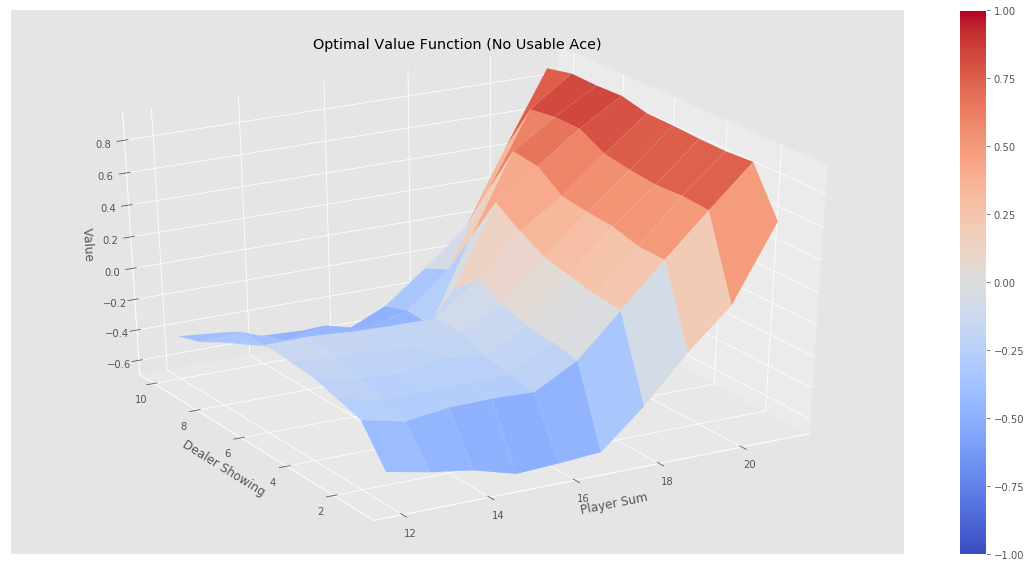

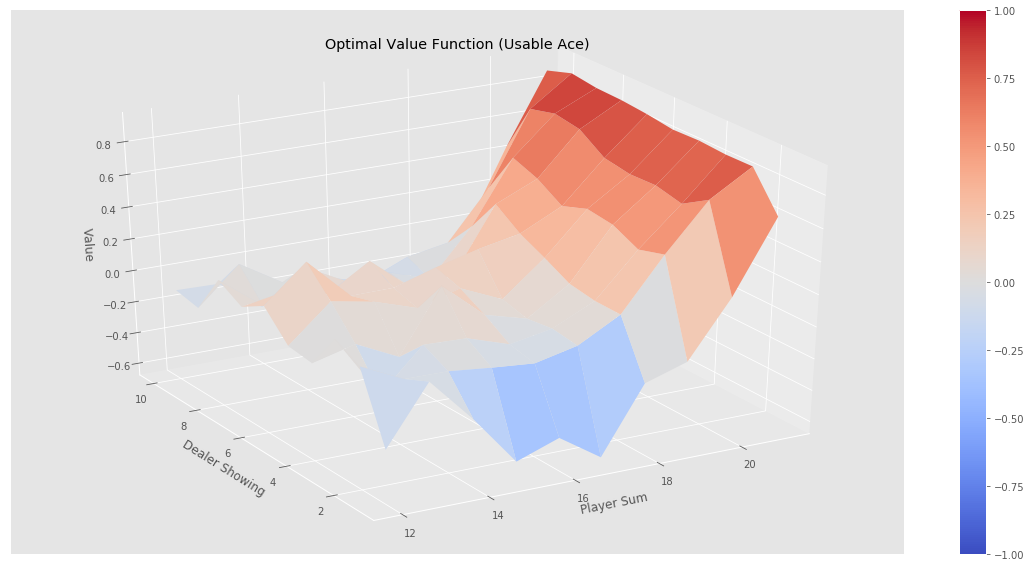

In [27]:
# For plotting: Create value function from action-value function
# by picking the best action at each state
V = defaultdict(float)
for state, action_values in Q.items():
    action_value = np.max(action_values)
    V[state] = action_value
plotting.plot_value_function(V, title="Optimal Value Function")